# TESTS MODELES STANDARDS

## I- Création des classes et méthodes de calculs

In [1]:
import numpy as np
from scipy import *
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from math import *
from classes_v2 import *    

Krigid,Grigid = 10**12,10**12

# Tests divers

In [2]:
Km,Gm,Kf,Gf,Kv,Gv=1,1,10,10,100,100
f = 0.5
inclusion=Inclusion(0, {"K":Kf, "G":Gf})
microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
Bounds=microstructure.Hashin_bounds()
Ch=Differential_Scheme().compute_h_behavior(microstructure)
print(Ch)
Ch=Mori_Tanaka().compute_h_behavior(microstructure)
print(Ch)
Ch=Eshelby_Approximation().compute_h_behavior(microstructure)
print(Ch)
Ch=Autocoherent_III().compute_h_behavior(microstructure)
print(Ch)


interphase=Inclusion(0, {"K":Kv, "G":Gv})
cf = 0.1
microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f,interphase:cf})
Ch=Autocoherent_IV().compute_h_behavior(microstructure)
print(Ch)

interphase=Inclusion(0, {"K":Kv, "G":Gv})
cf = 0.1
R1=1
microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f,interphase:cf})
Ch=Autocoherent_IV(R1).compute_h_behavior(microstructure)
print(Ch)

{'K': 2.853018447359099, 'G': 2.6255524164048856, 'E': 6.027636083659265, 'nu': 0.14787959402326123}
{'K': 2.5365853658536586, 'G': 2.3577586206896552, 'E': 5.4001328959719865, 'nu': 0.14518357574543037}
{'K': 1.9264705882352942, 'G': 1.799492385786802, 'E': 4.116693096417702, 'nu': 0.14384843440661105}
{'K': 2.536585365853658, 'G': 2.418886722022169, 'E': 5.506369599565397, 'nu': 0.13820327951573502}


NameError: The microstructure does not match the model hypothesis

## Test R1 et modèle 4-phases

In [ ]:
Km,Gm,Kf,Gf,Kv,Gv=1,1,10,10,100,100
f = 0.5
cf = 0.1
inclusion=Inclusion(0, {"K":Kf, "G":Gf})
interphase=Inclusion(0, {"K":Kv, "G":Gv})
microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f,interphase:cf})

K,G = [],[]
R1 = np.linspace(1,1000,1000)
for k in range(len(R1)) : 
    Ch=Autocoherent_IV(R1[k]).compute_h_behavior(microstructure)
    K.append(Ch['K'])
    G.append(Ch['G'])

plt.plot(R1,K)
plt.plot(R1,G)
plt.show()


## Cas poreux pour les schémas de Mori-Tanaka et Différentiel

Référence :  [Timothy J.J., Meschke G.,  2015.  A cascade continuum micromechanics model for the effective elastic properties of porous materials].

Fig A16 p10

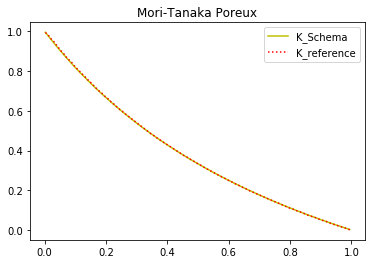

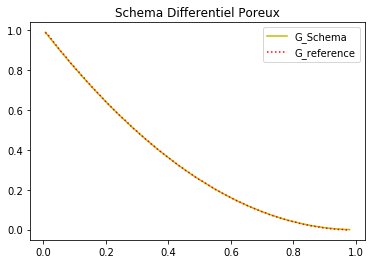

In [3]:
## Données
KHMT,KHDIF,KHSC = [],[],[]
FMT =  [0.0019559, 0.0058909, 0.0078565, 0.0098182, 0.0118, 0.0137, 0.0157, 0.0177, 0.0196, 0.0216, 0.0236, 0.0275, 0.0294, 0.0314, 0.0334, 0.0352, 0.0373, 0.0393, 0.0412, 0.0432, 0.0451, 0.0471, 0.0491, 0.051, 0.053, 0.0569, 0.0589, 0.0608, 0.0628, 0.0648, 0.0667, 0.0687, 0.0706, 0.0746, 0.0765, 0.0785, 0.0805, 0.0824, 0.0844, 0.0883, 0.0903, 0.0922, 0.0942, 0.0962, 0.1001, 0.1021, 0.104, 0.106, 0.1078, 0.1118, 0.1138, 0.1158, 0.1178, 0.1217, 0.1237, 0.1256, 0.1276, 0.1315, 0.1335, 0.1354, 0.1374, 0.1413, 0.1433, 0.1452, 0.1492, 0.1511, 0.1531, 0.157, 0.159, 0.161, 0.1649, 0.1668, 0.1688, 0.1727, 0.1747, 0.1767, 0.1806, 0.1826, 0.1865, 0.1884, 0.1904, 0.1943, 0.1963, 0.2002, 0.2022, 0.2061, 0.2081, 0.2101, 0.214, 0.2159, 0.2199, 0.2218, 0.2258, 0.2277, 0.2317, 0.2336, 0.2376, 0.2395, 0.2434, 0.2454, 0.2493, 0.2533, 0.2551, 0.2591, 0.261, 0.2651, 0.267, 0.2709, 0.2749, 0.2768, 0.2808, 0.2847, 0.2867, 0.2906, 0.2945, 0.2965, 0.3004, 0.3044, 0.3063, 0.3102, 0.3142, 0.3161, 0.3201, 0.324, 0.3279, 0.3299, 0.3338, 0.3378, 0.3417, 0.3436, 0.3476, 0.3515, 0.3554, 0.3594, 0.3633, 0.3653, 0.3692, 0.3731, 0.3771, 0.381, 0.3849, 0.3889, 0.3928, 0.3967, 0.4006, 0.4046, 0.4085, 0.4123, 0.4163, 0.4203, 0.4242, 0.4282, 0.4321, 0.436, 0.44, 0.4439, 0.4478, 0.4518, 0.4557, 0.4596, 0.4616, 0.4636, 0.4655, 0.4675, 0.4714, 0.4753, 0.4793, 0.4832, 0.487, 0.4891, 0.491, 0.495, 0.4989, 0.5029, 0.5068, 0.5107, 0.5147, 0.5186, 0.5225, 0.5265, 0.5304, 0.5343, 0.5383, 0.5422, 0.5461, 0.5501, 0.554, 0.5579, 0.5619, 0.5657, 0.5697, 0.5737, 0.5776, 0.5815, 0.5854, 0.5894, 0.5933, 0.5972, 0.6012, 0.6051, 0.609, 0.613, 0.6169, 0.6208, 0.6248, 0.6287, 0.6326, 0.6366, 0.6404, 0.6444, 0.6484, 0.6522, 0.6562, 0.6602, 0.6641, 0.668, 0.672, 0.6759, 0.6798, 0.6838, 0.6877, 0.6916, 0.6956, 0.6995, 0.7034, 0.7074, 0.7113, 0.7151, 0.7191, 0.7231, 0.7269, 0.7309, 0.7349, 0.7388, 0.7428, 0.7467, 0.7507, 0.7546, 0.7585, 0.7625, 0.7664, 0.7703, 0.7743, 0.7782, 0.7821, 0.7861, 0.79, 0.7939, 0.7979, 0.8018, 0.8056, 0.8096, 0.8136, 0.8175, 0.8215, 0.8254, 0.8293, 0.8333, 0.8372, 0.8411, 0.8451, 0.849, 0.8529, 0.8569, 0.8608, 0.8647, 0.8687, 0.8726, 0.8765, 0.8805, 0.8843, 0.8883, 0.8923, 0.8961, 0.9002, 0.9041, 0.908, 0.912, 0.9159, 0.9198, 0.9238, 0.9277, 0.9316, 0.9356, 0.9395, 0.9434, 0.9474, 0.9513, 0.9552, 0.9592, 0.963, 0.967, 0.971, 0.9748, 0.9788, 0.9828, 0.9867, 0.9907, 0.9946]
KMT =  [0.9931, 0.991, 0.9891, 0.9851, 0.9813, 0.9773, 0.9734, 0.9694, 0.9655, 0.9615, 0.9576, 0.9536, 0.9497, 0.9457, 0.9418, 0.9379, 0.9339, 0.93, 0.926, 0.9221, 0.9181, 0.9142, 0.9102, 0.9062, 0.9022, 0.8984, 0.8944, 0.8904, 0.8866, 0.8826, 0.8787, 0.8747, 0.8708, 0.8668, 0.8629, 0.8589, 0.855, 0.851, 0.8471, 0.8432, 0.8392, 0.8353, 0.8313, 0.8274, 0.8234, 0.8195, 0.8155, 0.8115, 0.8075, 0.8037, 0.7997, 0.7957, 0.7919, 0.7879, 0.784, 0.78, 0.7761, 0.7721, 0.7682, 0.7642, 0.7603, 0.7563, 0.7524, 0.7484, 0.7445, 0.7406, 0.7366, 0.7327, 0.7287, 0.7248, 0.7208, 0.7168, 0.7128, 0.709, 0.705, 0.701, 0.6971, 0.6932, 0.6893, 0.6853, 0.6814, 0.6774, 0.6735, 0.6695, 0.6656, 0.6616, 0.6577, 0.6537, 0.6498, 0.6459, 0.6419, 0.638, 0.634, 0.6301, 0.6261, 0.6221, 0.6181, 0.6143, 0.6103, 0.6064, 0.6024, 0.5985, 0.5945, 0.5906, 0.5867, 0.5827, 0.5788, 0.5748, 0.5709, 0.5669, 0.563, 0.559, 0.5551, 0.5511, 0.5472, 0.5432, 0.5393, 0.5354, 0.5314, 0.5274, 0.5234, 0.5196, 0.5156, 0.5117, 0.5077, 0.5038, 0.4998, 0.4959, 0.4919, 0.488, 0.484, 0.4801, 0.4762, 0.4722, 0.4683, 0.4643, 0.4604, 0.4564, 0.4525, 0.4485, 0.4445, 0.4405, 0.4367, 0.4327, 0.4288, 0.4248, 0.4209, 0.417, 0.413, 0.4091, 0.4051, 0.4012, 0.3972, 0.3933, 0.3893, 0.3854, 0.3814, 0.3775, 0.3735, 0.3716, 0.3696, 0.3676, 0.3656, 0.3637, 0.3597, 0.3558, 0.3518, 0.3479, 0.3458, 0.342, 0.34, 0.338, 0.3341, 0.3301, 0.3282, 0.3242, 0.3203, 0.3163, 0.3143, 0.3104, 0.3064, 0.3045, 0.3005, 0.2966, 0.2926, 0.2907, 0.2867, 0.2828, 0.2808, 0.2768, 0.2749, 0.2709, 0.267, 0.265, 0.261, 0.2591, 0.2551, 0.2511, 0.2492, 0.2453, 0.2433, 0.2393, 0.2374, 0.2334, 0.2314, 0.2275, 0.2255, 0.2216, 0.2196, 0.2157, 0.2137, 0.2097, 0.2078, 0.2038, 0.2018, 0.1979, 0.1959, 0.1939, 0.19, 0.188, 0.1841, 0.1821, 0.1801, 0.1762, 0.1742, 0.1703, 0.1683, 0.1663, 0.1623, 0.1604, 0.1584, 0.1545, 0.1525, 0.1505, 0.1466, 0.1446, 0.1426, 0.1387, 0.1367, 0.1347, 0.1328, 0.1288, 0.1268, 0.1249, 0.1209, 0.1189, 0.117, 0.115, 0.111, 0.1091, 0.1071, 0.1051, 0.1031, 0.0992, 0.0972, 0.0953, 0.0933, 0.0913, 0.0874, 0.0854, 0.0834, 0.0814, 0.0795, 0.0755, 0.0735, 0.0716, 0.0695, 0.0676, 0.0656, 0.0637, 0.0617, 0.0577, 0.0558, 0.0538, 0.0518, 0.0499, 0.0479, 0.0459, 0.0439, 0.042, 0.04, 0.036, 0.0341, 0.0321, 0.0301, 0.0281, 0.0262, 0.0242, 0.0222, 0.0202, 0.0183, 0.0163, 0.0143, 0.0123, 0.0104, 0.0083911, 0.0064168, 0.0044425, 0.00049577]
FDIF =  [0.0060129, 0.0080219, 0.01, 0.014, 0.016, 0.0181, 0.0201, 0.0221, 0.0241, 0.0261, 0.0281, 0.0301, 0.0321, 0.0341, 0.0361, 0.0381, 0.0401, 0.0421, 0.0441, 0.0461, 0.0481, 0.0501, 0.0521, 0.0541, 0.0561, 0.0582, 0.0602, 0.0622, 0.0662, 0.0682, 0.0702, 0.0722, 0.0742, 0.0762, 0.0782, 0.0802, 0.0822, 0.0842, 0.0862, 0.0882, 0.0923, 0.0943, 0.0963, 0.0983, 0.1003, 0.1023, 0.1043, 0.1063, 0.1083, 0.1123, 0.1143, 0.1163, 0.1183, 0.1203, 0.1223, 0.1243, 0.1263, 0.1304, 0.1324, 0.1344, 0.1364, 0.1384, 0.1404, 0.1444, 0.1464, 0.1484, 0.1504, 0.1524, 0.1544, 0.1585, 0.1605, 0.1625, 0.1645, 0.1665, 0.1705, 0.1724, 0.1745, 0.1764, 0.1785, 0.1825, 0.1844, 0.1865, 0.1885, 0.1926, 0.1945, 0.1966, 0.1985, 0.2026, 0.2046, 0.2066, 0.2086, 0.2126, 0.2146, 0.2166, 0.2186, 0.2227, 0.2247, 0.2267, 0.2307, 0.2327, 0.2347, 0.2387, 0.2407, 0.2427, 0.2447, 0.2487, 0.2508, 0.2528, 0.2568, 0.2588, 0.2628, 0.2648, 0.2668, 0.2708, 0.2728, 0.2748, 0.2789, 0.2809, 0.2849, 0.2869, 0.2889, 0.2929, 0.2949, 0.2989, 0.3009, 0.3029, 0.307, 0.309, 0.313, 0.315, 0.319, 0.321, 0.325, 0.327, 0.3311, 0.3331, 0.3371, 0.3391, 0.3431, 0.3451, 0.3491, 0.3511, 0.3551, 0.3571, 0.3612, 0.3632, 0.3672, 0.3712, 0.3732, 0.3772, 0.3792, 0.3833, 0.3873, 0.3893, 0.3933, 0.3973, 0.3993, 0.4033, 0.4074, 0.4094, 0.4134, 0.4174, 0.4194, 0.4234, 0.4274, 0.4315, 0.4335, 0.4375, 0.4415, 0.4455, 0.4495, 0.4515, 0.4556, 0.4596, 0.4636, 0.4676, 0.4716, 0.4756, 0.4776, 0.4817, 0.4837, 0.4857, 0.4877, 0.4897, 0.4937, 0.4977, 0.5018, 0.5058, 0.5098, 0.5118, 0.5138, 0.5158, 0.5178, 0.5219, 0.5259, 0.5299, 0.5339, 0.5379, 0.5419, 0.546, 0.548, 0.55, 0.554, 0.558, 0.562, 0.5661, 0.5701, 0.5741, 0.5781, 0.5821, 0.5862, 0.5901, 0.5941, 0.5981, 0.6021, 0.6063, 0.6103, 0.6143, 0.6183, 0.6223, 0.6263, 0.6303, 0.6343, 0.6383, 0.6423, 0.6465, 0.6505, 0.6545, 0.6585, 0.6625, 0.6665, 0.6705, 0.6745, 0.6785, 0.6825, 0.6867, 0.6907, 0.6947, 0.6987, 0.7027, 0.7067, 0.7107, 0.7147, 0.7187, 0.7229, 0.7269, 0.7309, 0.7349, 0.7389, 0.7429, 0.7469, 0.751, 0.755, 0.759, 0.7631, 0.7671, 0.7711, 0.7751, 0.7792, 0.7832, 0.7872, 0.7912, 0.7953, 0.7993, 0.8033, 0.8073, 0.8113, 0.8154, 0.8194, 0.8234, 0.8274, 0.8315, 0.8355, 0.8395, 0.8435, 0.8476, 0.8516, 0.8556, 0.8596, 0.8636, 0.8677, 0.8717, 0.8757, 0.8797, 0.8838, 0.8878, 0.8918, 0.8958, 0.8999, 0.9039, 0.9079, 0.9119, 0.916, 0.92, 0.924, 0.928, 0.9321, 0.9361, 0.9401, 0.9441, 0.9482, 0.9522, 0.9562, 0.9602, 0.9643, 0.9683, 0.9723, 0.9763, 0.9804]
KDIF =  [0.9868, 0.9849, 0.9809, 0.9768, 0.9727, 0.9687, 0.9647, 0.9607, 0.9567, 0.9527, 0.9487, 0.9445, 0.9405, 0.9365, 0.9325, 0.9285, 0.9245, 0.9205, 0.9165, 0.9123, 0.9083, 0.9043, 0.9003, 0.8963, 0.8923, 0.8883, 0.8843, 0.8801, 0.8761, 0.8721, 0.8681, 0.8641, 0.8601, 0.8561, 0.8521, 0.8479, 0.8439, 0.8399, 0.8359, 0.8319, 0.8279, 0.8239, 0.8197, 0.8157, 0.8117, 0.8077, 0.8037, 0.7997, 0.7957, 0.7917, 0.7875, 0.7835, 0.7795, 0.7755, 0.7715, 0.7675, 0.7635, 0.7595, 0.7553, 0.7513, 0.7473, 0.7433, 0.7393, 0.7353, 0.7313, 0.7271, 0.7231, 0.7191, 0.7151, 0.7111, 0.7071, 0.7031, 0.6991, 0.6949, 0.6909, 0.687, 0.6829, 0.6789, 0.6749, 0.6709, 0.6667, 0.6627, 0.6588, 0.6548, 0.6507, 0.6467, 0.6427, 0.6385, 0.6346, 0.6306, 0.6266, 0.6225, 0.6185, 0.6145, 0.6105, 0.6064, 0.6024, 0.5984, 0.5943, 0.5903, 0.5863, 0.5823, 0.5782, 0.5742, 0.5702, 0.5661, 0.5621, 0.5581, 0.5541, 0.55, 0.546, 0.542, 0.538, 0.5339, 0.5299, 0.5259, 0.5218, 0.5178, 0.5138, 0.5097, 0.5057, 0.5017, 0.4977, 0.4936, 0.4896, 0.4856, 0.4815, 0.4775, 0.4735, 0.4695, 0.4654, 0.4614, 0.4574, 0.4533, 0.4493, 0.4453, 0.4412, 0.4372, 0.4332, 0.4292, 0.4251, 0.4211, 0.4171, 0.413, 0.409, 0.405, 0.401, 0.3969, 0.3929, 0.3889, 0.3848, 0.3808, 0.3768, 0.3727, 0.3687, 0.3647, 0.3606, 0.3566, 0.3526, 0.3486, 0.3445, 0.3405, 0.3365, 0.3324, 0.3284, 0.3244, 0.3203, 0.3163, 0.3123, 0.3082, 0.3042, 0.3002, 0.2961, 0.2921, 0.2881, 0.284, 0.28, 0.276, 0.2719, 0.2679, 0.2659, 0.2639, 0.2619, 0.2598, 0.2558, 0.2518, 0.2477, 0.2437, 0.2417, 0.2397, 0.2376, 0.2356, 0.2336, 0.2296, 0.2255, 0.2215, 0.2175, 0.2134, 0.2094, 0.2074, 0.2033, 0.2013, 0.1993, 0.1953, 0.1912, 0.1892, 0.1852, 0.1811, 0.1791, 0.1751, 0.171, 0.169, 0.165, 0.161, 0.1589, 0.1549, 0.1529, 0.1488, 0.1448, 0.1428, 0.1387, 0.1367, 0.1347, 0.1306, 0.1286, 0.1246, 0.1226, 0.1185, 0.1165, 0.1145, 0.1104, 0.1084, 0.1064, 0.1024, 0.1003, 0.0983, 0.0963, 0.0922, 0.0902, 0.0882, 0.0862, 0.0841, 0.0821, 0.0781, 0.0761, 0.074, 0.072, 0.07, 0.0679, 0.0659, 0.0639, 0.0619, 0.0598, 0.0578, 0.0558, 0.0538, 0.0517, 0.0497, 0.0477, 0.0457, 0.0456, 0.0436, 0.0416, 0.0396, 0.0375, 0.0375, 0.0355, 0.0335, 0.0314, 0.0314, 0.0294, 0.0274, 0.0253, 0.0253, 0.0233, 0.0233, 0.0213, 0.0192, 0.0192, 0.0172, 0.0172, 0.0151, 0.0151, 0.0131, 0.0131, 0.011, 0.011, 0.0090047, 0.0089865, 0.0069603, 0.0069421, 0.006924, 0.0048978, 0.0048796, 0.0048614, 0.0028352, 0.002817, 0.0027988, 0.0027806, 0.00075439, 0.0007362, 0.00071801, 0.00069982, 0.00068163, 0.00066344, -0.0013628, -0.001381, -0.0013991, -0.0014173]
FSC =  [0.0121, 0.0161, 0.0202, 0.0242, 0.0262, 0.0283, 0.0303, 0.0323, 0.0363, 0.0384, 0.0424, 0.0465, 0.0505, 0.0545, 0.0586, 0.0626, 0.0667, 0.0707, 0.0727, 0.0748, 0.0768, 0.0788, 0.0808, 0.0849, 0.0889, 0.0929, 0.097, 0.101, 0.1051, 0.1091, 0.1131, 0.1172, 0.1212, 0.1232, 0.1253, 0.1273, 0.1293, 0.1314, 0.1354, 0.1394, 0.1435, 0.1475, 0.1516, 0.1556, 0.1596, 0.1637, 0.1677, 0.1698, 0.1718, 0.1738, 0.1758, 0.1778, 0.1819, 0.1859, 0.19, 0.194, 0.198, 0.2021, 0.2061, 0.2102, 0.2142, 0.2182, 0.2203, 0.2223, 0.2243, 0.2263, 0.2284, 0.2324, 0.2365, 0.2405, 0.2445, 0.2486, 0.2526, 0.2567, 0.2607, 0.2647, 0.2668, 0.2688, 0.2708, 0.2728, 0.2749, 0.2789, 0.2829, 0.287, 0.291, 0.2951, 0.2991, 0.3031, 0.3072, 0.3112, 0.3153, 0.3173, 0.3193, 0.3213, 0.3233, 0.3254, 0.3294, 0.3335, 0.3375, 0.3416, 0.3456, 0.3496, 0.3537, 0.3577, 0.3618, 0.3638, 0.3658, 0.3678, 0.3698, 0.3719, 0.3759, 0.38, 0.384, 0.388, 0.3921, 0.3961, 0.4002, 0.4042, 0.4082, 0.4123, 0.4143, 0.4163, 0.4183, 0.4203, 0.4224, 0.4264, 0.4304, 0.4344, 0.4386, 0.4426, 0.4466, 0.4506, 0.4546, 0.4588, 0.4607, 0.4628, 0.4649, 0.4668, 0.4689, 0.4729, 0.4769, 0.4809, 0.4851, 0.4891, 0.4931, 0.4971, 0.4992, 0.5013]
KSC =  [0.9825, 0.9747, 0.967, 0.9592, 0.9553, 0.9475, 0.9437, 0.9398, 0.9359, 0.9281, 0.9203, 0.9125, 0.9048, 0.897, 0.8893, 0.8815, 0.8737, 0.8659, 0.8582, 0.8542, 0.8504, 0.8465, 0.8426, 0.8349, 0.8271, 0.8193, 0.8115, 0.8037, 0.796, 0.7882, 0.7805, 0.7727, 0.7649, 0.761, 0.757, 0.7532, 0.7494, 0.7416, 0.7338, 0.7261, 0.7183, 0.7105, 0.7027, 0.6949, 0.6872, 0.6794, 0.6717, 0.6639, 0.66, 0.6561, 0.6522, 0.6484, 0.6406, 0.6328, 0.625, 0.6173, 0.6095, 0.6017, 0.5939, 0.5862, 0.5784, 0.5706, 0.5668, 0.5629, 0.559, 0.5551, 0.5473, 0.5396, 0.5318, 0.524, 0.5163, 0.5085, 0.5007, 0.4929, 0.4852, 0.4774, 0.4735, 0.4696, 0.4657, 0.4619, 0.4541, 0.4463, 0.4386, 0.4308, 0.423, 0.4152, 0.4075, 0.3997, 0.3919, 0.3841, 0.3764, 0.3725, 0.3686, 0.3647, 0.3608, 0.3531, 0.3453, 0.3375, 0.3298, 0.322, 0.3142, 0.3064, 0.2987, 0.2909, 0.2831, 0.2792, 0.2753, 0.2715, 0.2676, 0.2598, 0.2521, 0.2443, 0.2365, 0.2287, 0.221, 0.2132, 0.2054, 0.1977, 0.1899, 0.1821, 0.1782, 0.1743, 0.1705, 0.1666, 0.1588, 0.151, 0.1433, 0.1355, 0.1277, 0.1199, 0.1122, 0.1044, 0.0966, 0.0889, 0.0811, 0.0772, 0.0733, 0.0694, 0.0656, 0.0578, 0.05, 0.0422, 0.0345, 0.0267, 0.0189, 0.0112, 0.0033952, -0.00049056]

for i in range(len(FMT)):   
    f=FMT[i]
    Gm=1
    Km=4/3*Gm
    K=0
    G=0
    inclusion=Inclusion(0, {"K":K, "G":G}, 1)
    microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
    Ch=Mori_Tanaka().compute_h_behavior(microstructure)
    Kh=Ch['K']/Km
    KHMT.append(Kh)
    
for i in range(len(FDIF)): 
    f=FDIF[i]
    Gm=1
    Km=4/3*Gm
    K=0
    G=0
    inclusion=Inclusion(0, {"K":K, "G":G}, 1)
    microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
    Ch=Differential_Scheme().compute_h_behavior(microstructure)
    Kh=Ch['K']/Km
    KHDIF.append(Kh)

for i in range(len(FSC)): 
    f=FDIF[i]
    Gm=1
    Km=4/3*Gm
    K=10**-12
    G=10**-12
    inclusion=Inclusion(0, {"K":K, "G":G}, 1)
    microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
    Ch=Autocoherent_III().compute_h_behavior(microstructure)
    Kh=Ch['K']/Km
    KHSC.append(Kh)
    
plt.title("Mori-Tanaka Poreux")
plt.plot(FMT,KHMT,'y',label='K_Schema')
plt.plot(FMT,KMT,':r',label='K_reference')
plt.legend()
plt.show()

plt.title("Schema Differentiel Poreux")
plt.plot(FDIF,KHDIF,'y',label='G_Schema')
plt.plot(FDIF,KDIF,':r',label='G_reference')
plt.legend()
plt.show()

#plt.title("Schema Autocoherent Poreux")
#plt.plot(FSC,KHSC,'y',label='G_Schema')
#plt.plot(FSC,KSC,':r',label='G_reference')
#plt.legend()
#plt.show()
   

## Modèle d'Eshelby

### PROBLEME LE RESULTAT SORT TOUJOURS DES BORNES DE H-S

### Inclusion rigide

Référence : simplification de la formule : à trouver dans la littérature

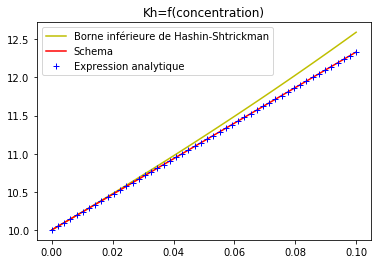

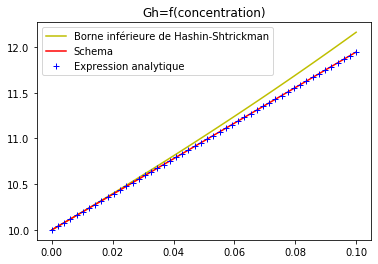

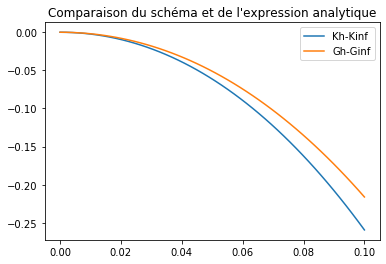

In [10]:
F=np.linspace(0,0.1,50)
Km,Gm,=10,10
KEsh,GEsh,Kform,Gform=[],[],[],[]
Kinf,Ksup,Gsup,Ginf = [],[],[],[]

for i in range(len(F)):
    f=F[i]
    inclusion=Inclusion(0, {"K":Krigid, "G":Grigid}, 1)
    microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
    model = Eshelby_Approximation()
    Ch=model.compute_h_behavior(microstructure)
    KEsh.append(Ch['K'])
    GEsh.append(Ch['G'])
    
    k=Km+f*(3*Km+4*Gm)/3
    g=Gm+5*f*Gm*(3*Km+4*Gm)/(6*Km+12*Gm)
    Kform.append(k)
    Gform.append(g)    
    
    Bounds=microstructure.Hashin_bounds()
    Gsup.append(Bounds['Gsup'])
    Ginf.append(Bounds['Ginf'])
    Ksup.append(Bounds['Ksup'])
    Kinf.append(Bounds['Kinf'])




plt.plot(F,Kinf,'y',label='Borne inférieure de Hashin-Shtrickman')
plt.plot(F,KEsh,'r',label='Schema')
plt.plot(F,Kform,'+b',label='Expression analytique')
plt.legend()
plt.title("Kh=f(concentration)")
plt.show()


plt.plot(F,Ginf,'y',label='Borne inférieure de Hashin-Shtrickman')
plt.plot(F,GEsh,'r',label='Schema')
plt.plot(F,Gform,'+b',label='Expression analytique')
plt.title("Gh=f(concentration)")
plt.legend()
plt.show()

Gdiff = np.array(GEsh)-np.array(Ginf)
Kdiff = np.array(KEsh)-np.array(Kinf) 
plt.plot(F,Kdiff,label='Kh-Kinf')
plt.plot(F,Gdiff,label='Gh-Ginf')
plt.legend()
plt.title("Comparaison du schéma et de l'expression analytique")
plt.show()

## Inclusion rigide et matrice incompressible

Reference : formule simplifiée

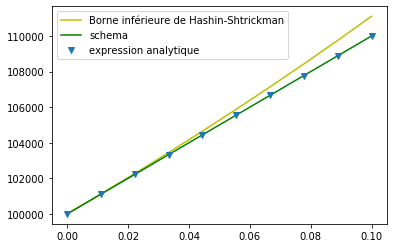

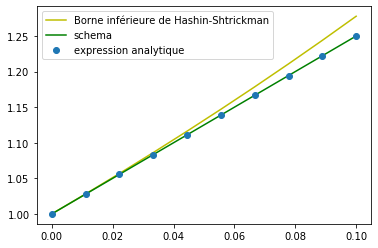

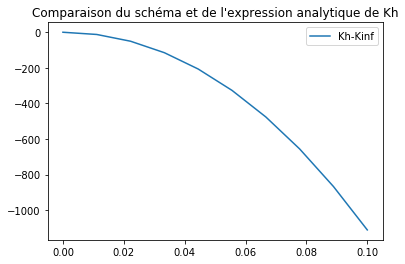

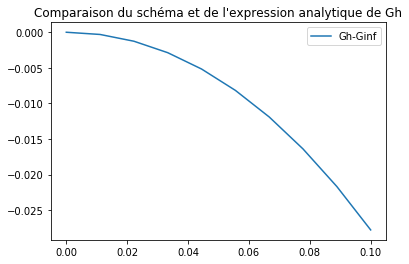

In [11]:
F=np.linspace(0,0.1,10)
Km,Gm=100000,1
KEsh,GEsh,Kform,Gform=[],[],[],[]
Kinf,Ksup,Gsup,Ginf = [],[],[],[]

for i in range(len(F)):
    f=F[i]
    inclusion=Inclusion(0, {"K":Krigid, "G":Grigid}, 1)
    microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
    model = Eshelby_Approximation()
    Ch=model.compute_h_behavior(microstructure)
    KEsh.append(Ch['K'])
    GEsh.append(Ch['G'])
    
    k=Km+f*Km
    g=Gm+5*f*Gm/2
    Kform.append(k)
    Gform.append(g)    
    
    Bounds=microstructure.Hashin_bounds()
    Gsup.append(Bounds['Gsup'])
    Ginf.append(Bounds['Ginf'])
    Ksup.append(Bounds['Ksup'])
    Kinf.append(Bounds['Kinf'])



plt.plot(F,Kinf,'y',label='Borne inférieure de Hashin-Shtrickman')
plt.plot(F,KEsh,'g',label='schema')
plt.plot(F,Kform,'v',label='expression analytique')
plt.legend()

plt.show()

plt.plot(F,Ginf,'y',label='Borne inférieure de Hashin-Shtrickman')
plt.plot(F,GEsh,'g',label='schema')
plt.plot(F,Gform,'o',label='expression analytique')
plt.legend()
plt.show()

Gdiff = np.array(GEsh)-np.array(Ginf)
Kdiff = np.array(KEsh)-np.array(Kinf) 
plt.plot(F,Kdiff,label='Kh-Kinf')
plt.legend()
plt.title("Comparaison du schéma et de l'expression analytique de Kh")
plt.show()

plt.plot(F,Gdiff,label='Gh-Ginf')
plt.legend()
plt.title("Comparaison du schéma et de l'expression analytique de Gh")
plt.show()

## Schéma Différentiel

### Comparaison intégrale/itération

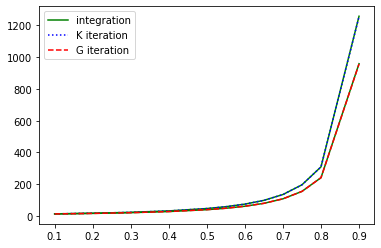

In [12]:
npoints=10000
F=[0.1,0.2,0.3,0.4,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.9]
Km,Gm,Kf,Gf=10,10,10**15,10**15
KH,GH,KT,GT=[],[],[],[]

for i in range(len(F)):
    f=F[i]
    inclusion=Inclusion(0, {"K":Kf, "G":Gf}, 1)
    microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
    model = Differential_Scheme()
    Ch=model.compute_h_behavior(microstructure)
    KH.append(Ch['K'])
    GH.append(Ch['G'])
    
    dc=f/npoints
    K,G=Km,Gm
    c=0
    for i in range (npoints):
        dK,dG,dKf,dGf=Differential_Scheme.deriv([K,G,Kf,Gf],c)
        K+=dc*dK
        G+=dc*dG
        c+=dc
    KT.append(K)
    GT.append(G)    

plt.plot(F,KH,'g',label='integration')
plt.plot(F,KT,':b',label='K iteration')
plt.plot(F,GH,'g')
plt.plot(F,GT,'--r',label='G iteration')
plt.legend()
plt.show()

### Inclusion parfaitement rigide et concentration pas trop élevée

Référence :  [Christensen,  R.M.,  1990.  A critical evaluation for a class of micromechanics models].

Equation (7) and (8) p5

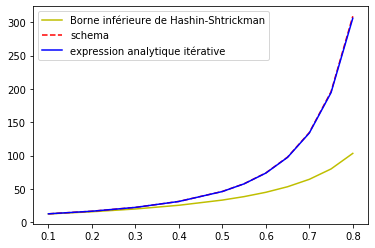

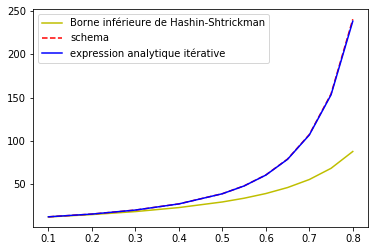

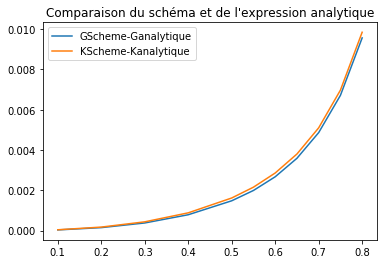

In [13]:
npoints=1000
F=[0.1,0.2,0.3,0.4,0.5,0.55,0.6,0.65,0.7,0.75,0.8]
Km,Gm=10,10
KScheme,GScheme,Kit,Git=[],[],[],[]
Kinf,Ksup,Gsup,Ginf = [],[],[],[]

def SuivantInclusionRigide(k,g,c,dc):
    nextk=k+dc*(k+4*g/3)/(1-c)
    nextg=g+dc*5*g*(3*k+4*g)/(6*(k+2*g)*(1-c))
    return nextk,nextg,c+dc

for i in range(len(F)):
    f=F[i]
    inclusion=Inclusion(0, {"K":Krigid, "G":Grigid}, 1)
    microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
    model = Differential_Scheme()
    Ch=model.compute_h_behavior(microstructure)

    dc=f/npoints
    k,K,g,G=Km,Gm,Km,Gm
    c=0
    for i in range (npoints):
        k,g,c=SuivantInclusionRigide(k,g,c,dc)
    KScheme.append(Ch['K'])
    GScheme.append(Ch['G'])
    Kit.append(k)
    Git.append(g)    
    
    Bounds=microstructure.Hashin_bounds()
    Gsup.append(Bounds['Gsup'])
    Ginf.append(Bounds['Ginf'])
    Ksup.append(Bounds['Ksup'])
    Kinf.append(Bounds['Kinf'])



plt.plot(F,Kinf,'y',label='Borne inférieure de Hashin-Shtrickman')
plt.plot(F,KScheme,'--r',label='schema')
plt.plot(F,Kit,'b',label='expression analytique itérative')
plt.legend()
plt.show()

plt.plot(F,Ginf,'y',label='Borne inférieure de Hashin-Shtrickman')
plt.plot(F,GScheme,'--r',label='schema')
plt.plot(F,Git,'b',label='expression analytique itérative')
plt.legend()
plt.show()

Gdiff = (np.array(GScheme)-np.array(Git))/np.array(Git)
Kdiff = (np.array(KScheme)-np.array(Kit))/np.array(Kit) 
plt.plot(F,Gdiff,label='GScheme-Ganalytique')
plt.plot(F,Kdiff,label='KScheme-Kanalytique')
plt.legend()
plt.title("Comparaison du schéma et de l'expression analytique")
plt.show()

### Inclusion rigide et matrice incompressible et concentration pas trop élevée

Référence :  [Christensen,  R.M.,  1990.  A critical evaluation for a class of micromechanics models].

Equation (12) and (13) p6

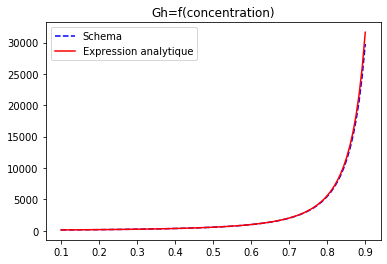

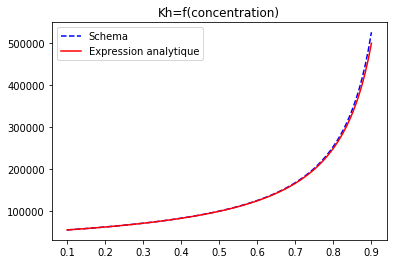

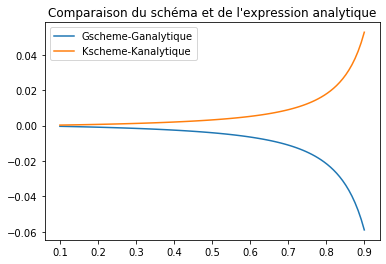

In [14]:
F=np.linspace(0.1,0.9,100)
LK=[]
LKT=[]
LG=[]
LGT=[]
for i in range(len(F)):
    f=F[i]
    Em=300
    mum=0.499
    Km=Em/(3-6*mum)
    Gm=Em/(2+2*mum)
    inclusion=Inclusion(0, {"K":Krigid, "G":Grigid}, 1)
    microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
    model = Differential_Scheme()
    Ch=model.compute_h_behavior(microstructure)
    LK.append(Ch['K'])
    LG.append(Ch['G'])
    LGT.append(Gm/(1-f)**(5/2))
    LKT.append(Km/(1-f))



plt.plot(F,LG,'--b',label='Schema')
plt.plot(F,LGT,'r',label='Expression analytique')
plt.legend()
plt.title("Gh=f(concentration)")
plt.show()

plt.plot(F,LK,'--b',label='Schema')
plt.plot(F,LKT,'r',label='Expression analytique')
plt.legend()
plt.title("Kh=f(concentration)")
plt.show()

Gdiff = (np.array(LG)-np.array(LGT))/np.array(LGT)
Kdiff = (np.array(LK)-np.array(LKT))/np.array(LKT) 
plt.plot(F,Gdiff,label='Gscheme-Ganalytique')
plt.plot(F,Kdiff,label='Kscheme-Kanalytique')
plt.legend()
plt.title("Comparaison du schéma et de l'expression analytique")
plt.show()

### Inclusion rigide, mu=0,2 et concentration pas trop élevée

Référence :  [Christensen,  R.M.,  1990.  A critical evaluation for a class of micromechanics models].

Equation (19) p7

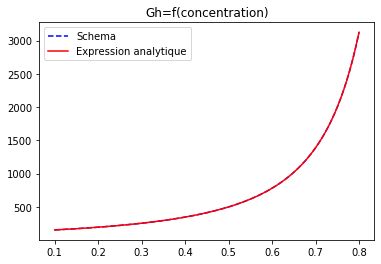

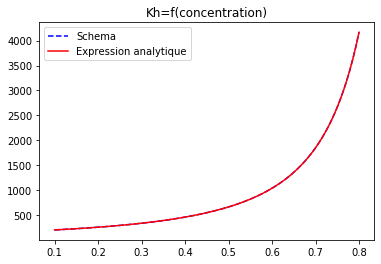

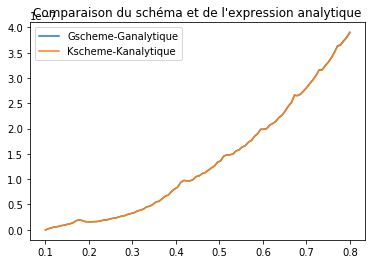

In [15]:
F=np.linspace(0.1,0.8,100)
LK=[]
LKT=[]
LG=[]
LGT=[]
for i in range(len(F)):
    f=F[i]
    Em=300
    mum=0.2
    Km=Em/(3-6*mum)
    Gm=Em/(2+2*mum)
    inclusion=Inclusion(0, {"K":Krigid, "G":Grigid}, 1)
    microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
    model = Differential_Scheme()
    Ch=model.compute_h_behavior(microstructure)
    LK.append(Ch['K'])
    LG.append(Ch['G'])
    LGT.append(Gm/(1-f)**2)
    LKT.append(Km/(1-f)**2)

plt.plot(F,LG,'--b',label='Schema')
plt.plot(F,LGT,'r',label='Expression analytique')
plt.legend()
plt.title("Gh=f(concentration)")
plt.show()

plt.plot(F,LK,'--b',label='Schema')
plt.plot(F,LKT,'r',label='Expression analytique')
plt.legend()
plt.title("Kh=f(concentration)")
plt.show()

Gdiff = (np.array(LG)-np.array(LGT))/np.array(LGT)
Kdiff = (np.array(LK)-np.array(LKT))/np.array(LKT) 
plt.plot(F,Gdiff,label='Gscheme-Ganalytique')
plt.plot(F,Kdiff,label='Kscheme-Kanalytique')
plt.legend()
plt.title("Comparaison du schéma et de l'expression analytique")
plt.show()

### Haute concentration et matrice incompressible inclusion parfaitement rigide

Référence :  [Christensen,  R.M.,  1990.  A critical evaluation for a class of micromechanics models].

Equation (29) p8

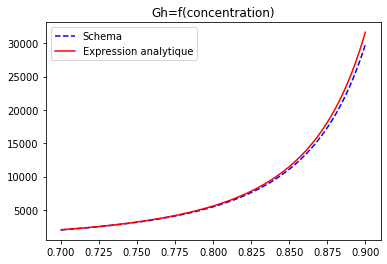

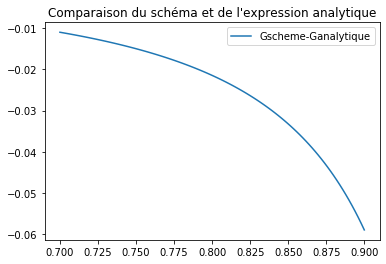

In [16]:
F=np.linspace(0.7,0.9,100)
LK=[]
LKT=[]
LG=[]
LGT=[]
for i in range(len(F)):
    f=F[i]
    Em=300
    mum=0.499
    Km=Em/(3-6*mum)
    Gm=Em/(2+2*mum)
    inclusion=Inclusion(0, {"K":Krigid, "G":Krigid}, 1)
    microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
    model = Differential_Scheme()
    Ch=model.compute_h_behavior(microstructure)
    LG.append(Ch['G'])
    LGT.append(Gm/(1-f)**(5/2))

    
plt.plot(F,LG,'--b',label='Schema')
plt.plot(F,LGT,'r',label='Expression analytique')
plt.legend()
plt.title("Gh=f(concentration)")
plt.show()

Gdiff = (np.array(LG)-np.array(LGT))/np.array(LGT)
plt.plot(F,Gdiff,label='Gscheme-Ganalytique')
plt.legend()
plt.title("Comparaison du schéma et de l'expression analytique")
plt.show()

# Schéma de Mori-Tanaka
### Inclusion rigide

Référence :  [Christensen,  R.M.,  1990.  A critical evaluation for a class of micromechanics models].

Equation (64) p15

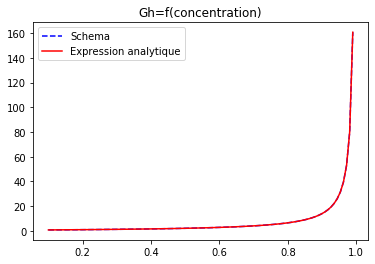

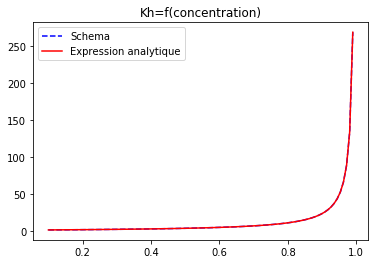

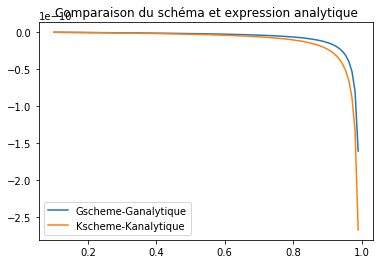

In [17]:
F=np.linspace(0.1,0.99,99)
LK=[]
LKT=[]
LG=[]
LGT=[]
for i in range(1,100):
    f=i/100
    Em=2
    mum=0.3
    Km=Em/(3-6*mum)
    Gm=Em/(2+2*mum)
    inclusion=Inclusion(0, {"K":Krigid, "G":Grigid}, 1)
    microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
    model = Mori_Tanaka()
    Ch=model.compute_h_behavior(microstructure)
    LK.append(Ch['K'])
    LG.append(Ch['G'])
    LGT.append(Gm*(1+f/(1-f)*(1+(9*Km+8*Gm)/(6*Km+12*Gm))))
    LKT.append(Km*(1+f/(1-f)*(1+4*Gm/(3*Km))))
    
plt.plot(F,LG,'--b',label='Schema')
plt.plot(F,LGT,'r',label='Expression analytique')
plt.legend()
plt.title("Gh=f(concentration)")
plt.show()

plt.plot(F,LK,'--b',label='Schema')
plt.plot(F,LKT,'r',label='Expression analytique')
plt.legend()
plt.title("Kh=f(concentration)")
plt.show()

Gdiff = (np.array(LG)-np.array(LGT))/np.array(LGT)
Kdiff = (np.array(LK)-np.array(LKT))/np.array(LKT) 
plt.plot(F,Gdiff,label='Gscheme-Ganalytique')
plt.plot(F,Kdiff,label='Kscheme-Kanalytique')
plt.legend()
plt.title("Comparaison du schéma et expression analytique")
plt.show()


### Inclusion rigide et matrice incompressible

Référence :  [Christensen,  R.M.,  1990.  A critical evaluation for a class of micromechanics models].

Equation (65) p15

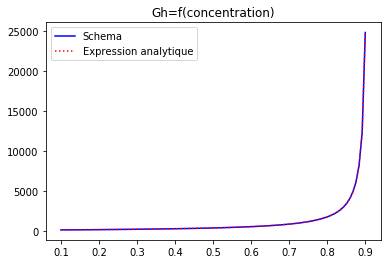

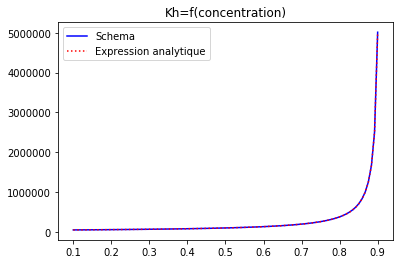

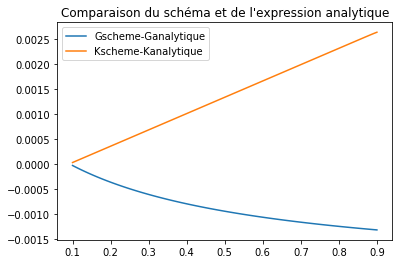

In [26]:
F=np.linspace(0.1,0.9,99)
LK=[]
LKT=[]
LG=[]
LGT=[]
for i in range(1,100):
    f=i/100
    Em=300
    mum=0.499
    Km=Em/(3-6*mum)
    Gm=Em/(2+2*mum)
    inclusion=Inclusion(0, {"K":Krigid, "G":Grigid}, 1)
    microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
    model = Mori_Tanaka()
    Ch=model.compute_h_behavior(microstructure)
    LK.append(Ch['K'])
    LG.append(Ch['G'])
    LGT.append(Gm*(1+3*f/2)/(1-f))
    LKT.append(Km/(1-f))
    
plt.plot(F,LG,'b',label='Schema')
plt.plot(F,LGT,':r',label='Expression analytique')
plt.legend()
plt.title("Gh=f(concentration)")
plt.show()

plt.plot(F,LK,'b',label='Schema')
plt.plot(F,LKT,':r',label='Expression analytique')
plt.legend()
plt.title("Kh=f(concentration)")
plt.show()

Gdiff = (np.array(LG)-np.array(LGT))/np.array(LGT)
Kdiff = (np.array(LK)-np.array(LKT))/np.array(LKT) 
plt.plot(F,Gdiff,label='Gscheme-Ganalytique')
plt.plot(F,Kdiff,label='Kscheme-Kanalytique')
plt.legend()
plt.title("Comparaison du schéma et de l'expression analytique")
plt.show()

### Concentration élévées (f->1) inclusions rigides et matrice compressible

Référence :  [Christensen,  R.M.,  1990.  A critical evaluation for a class of micromechanics models].

Table 2 p16

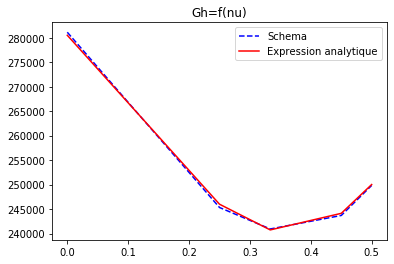

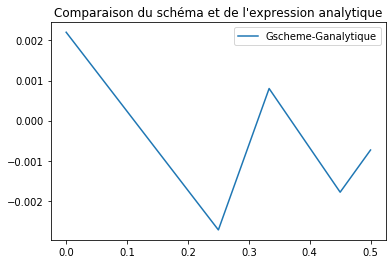

In [19]:
Nu=[0,1/4,1/3,0.45,0.4999]
Alpha=[1.87,2.05,2.14,2.36,2.5]
LG=[]
LGT=[]

for i in range(len(Nu)):
    f=0.999
    Em=300
    num=Nu[i]
    Km=Em/(3-6*num)
    Gm=Em/(2+2*num)
    inclusion=Inclusion(0, {"K":Krigid, "G":Grigid}, 1)
    microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
    model = Mori_Tanaka()
    Ch=model.compute_h_behavior(microstructure)
    LG.append(Ch['G'])
    LGT.append(Gm*Alpha[i]/(1-f))
    
plt.plot(Nu,LG,'--b',label='Schema')
plt.plot(Nu,LGT,'r',label='Expression analytique')
plt.legend()
plt.title("Gh=f(nu)")
plt.show()


Gdiff = (np.array(LG)-np.array(LGT))/np.array(LGT)
plt.plot(Nu,Gdiff,label='Gscheme-Ganalytique')
plt.legend()
plt.title("Comparaison du schéma et de l'expression analytique")
plt.show()

### Cas particulier : mu=1/5,  comparaison des modèles Mori-Tanaka et Differentiel

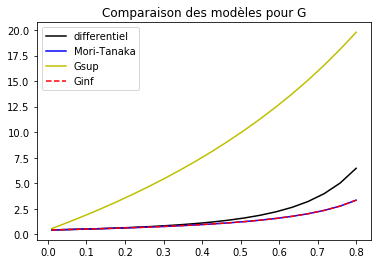

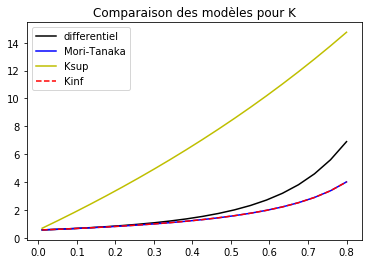

In [20]:
F=np.linspace(0.01,0.8,20)
Kdiff,Gdiff, KMT,GMT,Kinf,Ksup,Gsup,Ginf = [],[],[],[],[],[],[],[]
for i in range(len(F)):
    f=F[i]
    Em=1
    num=0.2
    Km=Em/(3-6*num)
    Gm=Em/(2+2*num)
    K=20
    G=30
    inclusion=Inclusion(0, {"K":K, "G":G}, 1)
    microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
    Bounds=microstructure.Hashin_bounds()
    Gsup.append(Bounds['Gsup'])
    Ginf.append(Bounds['Ginf'])
    Ksup.append(Bounds['Ksup'])
    Kinf.append(Bounds['Kinf'])
    
    modeldiff = Differential_Scheme()
    Chdiff=modeldiff.compute_h_behavior(microstructure)
    Kdiff.append(Chdiff['K'])
    Gdiff.append(Chdiff['G'])
    
    modelmt = Mori_Tanaka()
    Chmt = modelmt.compute_h_behavior(microstructure)
    GMT.append(Chmt['G'])
    KMT.append(Chmt['K'])
    

plt.title("Comparaison des modèles pour G")
plt.plot(F,Gdiff,'k',label='differentiel')
plt.plot(F,GMT,'b',label='Mori-Tanaka')
plt.plot(F,Gsup,'y',label='Gsup')
plt.plot(F,Ginf,'--r',label='Ginf')
plt.legend()
plt.show() 

plt.title("Comparaison des modèles pour K")
plt.plot(F,Kdiff,'k',label='differentiel')
plt.plot(F,KMT,'b',label='Mori-Tanaka')
plt.plot(F,Ksup,'y',label='Ksup')
plt.plot(F,Kinf,'--r',label='Kinf')
plt.legend()
plt.show()

## Bornes de Hashin-Shtrickman

### Test du modèle des bornes de Hashin-Shtrickman pour K,G>Km,Gm

Référence : [Hashin, Z., and Shtrikman, S., 1963.  A Variational Approach to the Theory of the Elastic Behaviour of Multiphase Materials.J. Mech.  Phys.  Solids, 11, 127–140].

Datas : Fig 1 and 2 p136

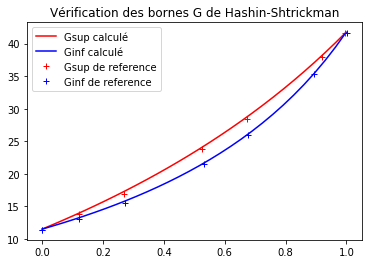

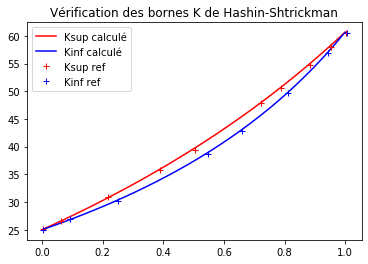

In [21]:
## Données : 
K,G = 60.7,41.8
Km,Gm = 25,11.5

FGinf = [0.000771508, 0.122418131, 0.272279371, 0.530682701, 0.676225717, 0.893925994, 1.000617946]
Ginf = [11.37606358, 13.08246844, 15.49789621, 21.45086489, 25.97007948, 35.35147265, 41.64721833]
FGsup = [0.000771508,0.120567993, 0.26919519, 0.526210916, 0.673759482, 0.919211841, 0.996917669]
Gsup = [11.37606358,13.83048153, 16.91603553, 23.81178121, 28.44787284, 38.00065451, 41.61608228]
FKinf = [0.00267784, 0.090936685, 0.249534451, 0.546089385, 0.657821229, 0.811297952, 0.944599628, 1.004189944]
Kinf = [24.95709828, 26.84864275, 30.24964119, 38.6349454, 42.82371295, 49.65678627, 56.8174727, 60.51482059]
FKsup = [0.004422719, 0.062849162, 0.217877095, 0.389664804, 0.502793296, 0.722843575, 0.788640596, 0.884078212, 0.954376164, 1.003724395]
Ksup =[25.0975039, 26.65366615, 30.88923557, 35.75663027, 39.38377535, 47.78471139, 50.54602184, 54.75819033, 58.01092044, 60.56939158]

F=np.linspace(0.0001,0.999,30)
kinf,ksup,gsup,ginf = [],[],[],[]
for i in range(len(F)):
    f = F[i]
    inclusion=Inclusion(0, {"K":K, "G":G}, 1)
    microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
    Bounds=microstructure.Hashin_bounds()
    gsup.append(Bounds['Gsup'])
    ginf.append(Bounds['Ginf'])
    ksup.append(Bounds['Ksup'])
    kinf.append(Bounds['Kinf'])


plt.plot(F,gsup,'r',label='Gsup calculé')
plt.plot(F,ginf,'b',label='Ginf calculé')
plt.plot(FGsup,Gsup,'+r',label='Gsup de reference')
plt.plot(FGinf,Ginf,'+b',label='Ginf de reference')
plt.legend()
plt.title("Vérification des bornes G de Hashin-Shtrickman")
plt.show()

plt.plot(F,ksup,'r',label='Ksup calculé')
plt.plot(F,kinf,'b',label='Kinf calculé')
plt.plot(FKsup,Ksup,'+r',label='Ksup ref')
plt.plot(FKinf,Kinf,'+b',label='Kinf ref')
plt.title("Vérification des bornes K de Hashin-Shtrickman")
plt.legend()
plt.show()